In [1]:
# Analysis of Facebook likes using "harmonic" crowdsourcing algorithm.
# This is an analysis performed entirely on the users who have liked both good and bad items; 
# this intersection forms the hardest "core" of the problem.

In [2]:
%matplotlib inline
# import json_plus
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import voting
import matplotlib

In [3]:
# Set figure size.
matplotlib.rcParams['figure.figsize'] = (4.0, 2.0)
matplotlib.rcParams['errorbar.capsize'] = 5
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt.rc('text', usetex=True)
# plt.rc('font', family='serif')


In [4]:
# Data loading
with open('../dataset/retweeters.json') as data_file:
    data = json.load(data_file)
print("Loaded.")

Loaded.


In [5]:
# Counts
post_list = [i for i in data.keys()]
user_list = []
for i in data.values():
    user_list.extend(i)
user_set = set(user_list)
nlikes = len(user_list)
nuser = len(user_set)
nposts = len(data)
print('N. of posts: %s' % nposts)
print('N. of likes %d' % nlikes)
print('N. of unique users: %s' % nuser)
print('Avg. likes per user: %.2f' % (nlikes/nuser))
print('Avg. likes per post: %.2f' % (nlikes/nposts))

N. of posts: 15727
N. of likes 98782
N. of unique users: 11496
Avg. likes per user: 8.00
Avg. likes per post: 6.00


In [6]:
# Hoax pages
pages = set([i.split('_')[0] for i in post_list])
# WARNING: commented out pages DO NOT EXIST.
hoax_pages = {'844805327254011905','241488377','1359279284','1073461458','864116008910548992','2863515755','1045260886997430272','88763077','930919729254010885'}
nonhoax_pages = pages - hoax_pages
error_pages = hoax_pages - pages
if len(error_pages) > 0:
    print "Error: some hoax pages never appear:", error_pages
print("N. of pages: %d hoax vs. %d non-hoax" % (len(hoax_pages), len(nonhoax_pages)))
print "Hoax pages:", hoax_pages
print "Nonhoax pages:", nonhoax_pages

N. of pages: 9 hoax vs. 14 non-hoax
Hoax pages: set(['1359279284', '241488377', '1073461458', '930919729254010885', '2863515755', '844805327254011905', '88763077', '864116008910548992', '1045260886997430272'])
Nonhoax pages: set([u'469251331', u'581793998', u'47295451', u'19179390', u'1901341021', u'37664893', u'86058123', u'831151718', u'194399035', u'493172275', u'39480709', u'86022744', u'14493047', u'562800078'])


In [7]:
# Hoax post categorization
hoax_posts = {x for x in data if x.split('_')[0] in hoax_pages}
print("N. of posts: %d hoax vs. %d non-hoax" % (len(hoax_posts), nposts-len(hoax_posts)))

N. of posts: 5698 hoax vs. 10029 non-hoax


In [8]:
# Computes the number of posts per each page.
posts_per_page = {}
for p, ul in data.items():
    page = p.split('_')[0]
    posts_per_page[page] = posts_per_page.get(page, 0.0) + 1.0
print posts_per_page

{u'581793998': 985.0, u'241488377': 668.0, u'930919729254010885': 1740.0, u'864116008910548992': 212.0, u'39480709': 544.0, u'37664893': 58.0, u'1901341021': 292.0, u'562800078': 869.0, u'86058123': 127.0, u'831151718': 417.0, u'2863515755': 71.0, u'194399035': 1674.0, u'844805327254011905': 253.0, u'1359279284': 2.0, u'469251331': 305.0, u'47295451': 2170.0, u'19179390': 444.0, u'493172275': 63.0, u'88763077': 99.0, u'1045260886997430272': 154.0, u'1073461458': 2499.0, u'14493047': 1753.0, u'86022744': 328.0}


In [9]:
def graph_correct(d):
    """Makes a graph of the correctness as a function of number of likes."""
    print "Accuracy overall:", d['ratio_correct']
    # Now for the graph. 
    ys = d['ratio_correct_likes']
    xs = range(1, 1 + len(ys))
    plt.plot(xs, ys, 'bo')
    plt.xlabel('Number of likes')
    plt.ylabel('Fraction correct')
    plt.ylim(ymax=1.01)
    plt.show()

In [10]:
# Now let's compute the set of users who have voted for BOTH good and bad items. 
hoax_users = set()
nonhoax_users = set()
for p, ul in data.items():
    page = p.split('_')[0]
    # The truth value depends on the page.
    tv = not (page in hoax_pages)
    if tv:
        nonhoax_users.update(ul)
    else:
        hoax_users.update(ul)
users_liked_both = hoax_users & nonhoax_users
print "Number of user who liked both type of pages:", len(users_liked_both)
    

Number of user who liked both type of pages: 2167


In [11]:
# I want to know, how many of the users above have voted for ONLY two pages.
user_cardinality = {}
for p, ul in data.items():
    for u in ul:
        if u in users_liked_both:
            user_cardinality[u] = 1 + user_cardinality.get(u, 0)
num_with_card_2 = 0
for u, c in user_cardinality.items():
    if c == 2:
        num_with_card_2 += 1
print "Number of users in intersection dataset with cardinality 2:", num_with_card_2

Number of users in intersection dataset with cardinality 2: 283


In [12]:
# Let's compute the set of users who have voted for more than one page.
pages_user = {}
for p, ul in data.items():
    page = p.split('_')[0]
    for u in ul:
        pages_user[u] = pages_user.get(u, set()) | {p}
multi_page_users = set([u for u, ps in pages_user.items() if len(ps) > 1])
print "Numner of users who liked more than one page:", len(multi_page_users)

Numner of users who liked more than one page: 6201


In [13]:
# Run this code AFTER computing the set of hoax users above.
def add_data(g, use_all=False, use_atleast_two=False):
    """Adds the data to a graph g.
    If use_all is True, it uses all data; otherwise it uses data only from the intersection dataset."""
    for p, ul in data.items():
        page = p.split('_')[0]
        # The truth value depends on the page.
        tv = not (page in hoax_pages)
        for u in ul:
            # The polarity is always 1 (pos).
            if use_all or (u in users_liked_both) or (use_atleast_two and u in multi_page_users):
                g.add_edge(u, p, item_true_value=tv)
    print("The graph has been built!")

In [14]:
# Let's get some stats.
reload(voting)
g = voting.VotingGraph()
add_data(g)
g.print_stats()

The graph has been built!
Num items: 12562
Num items with truth known: 12562
Num items with inferred known: 0
Num items testing: 0
Min degree: 1
Num users: 2167
Num likes: 54938


In [15]:
# Let's get some stats.
reload(voting)
g = voting.VotingGraph()
add_data(g, use_all=True)
g.print_stats()

The graph has been built!
Num items: 15649
Num items with truth known: 15649
Num items with inferred known: 0
Num items testing: 0
Min degree: 1
Num users: 11496
Num likes: 98782


In [16]:
# 5 fold validation
reload(voting)
TESTS = [ 2, 2, 2, 2, 2]
results_all_x = []
results_all_y = []
results_all_err = []
g = voting.VotingGraph()
add_data(g, use_all=True)
for f in TESTS:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_all_x.append(f)
    results_all_y.append(d['ratio_correct'])
    results_all_err.append(d['stdev'])

The graph has been built!
2 0.926722044728
2 0.925891373802
2 0.926819169329
2 0.926808945687
2 0.926819169329


In [17]:
res_all_y = np.mean(results_all_y) 
print('res_all_y = %s' % str(res_all_y))

res_all_err = np.mean(results_all_err)
print('res_all_err = %s' % str(res_all_err))

res_all_y = 0.9266121405750798
res_all_err = 0.002510250207789704


In [18]:
# 5 fold validation  -  Now for the intersection dataset.
reload(voting)
results_intersection_x = []
results_intersection_y = []
results_intersection_err = []
TESTS = [ 2, 2,2,2,2]
g = voting.VotingGraph()
add_data(g, use_all=False)
for f in TESTS:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_intersection_x.append(f)
    results_intersection_y.append(d['ratio_correct'])
    results_intersection_err.append(d['stdev'])

The graph has been built!
2 0.887412832352
2 0.887234516797
2 0.88649259672
2 0.886846043624
2 0.886750517434


In [19]:
res_all_y = np.mean(results_intersection_y) 
print('res_all_y = %s' % str(res_all_y))

res_all_err = np.mean(results_intersection_err)
print('res_all_err = %s' % str(res_all_err))

res_all_y = 0.8869473013851298
res_all_err = 0.0037495447357492676


In [20]:
reload(voting)
TESTS = [ 2, 5, 10, 20, 50, 100, 200, 400]
results_all_x = []
results_all_y = []
results_all_err = []
g = voting.VotingGraph()
add_data(g, use_all=True)
for f in TESTS:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_all_x.append(f)
    results_all_y.append(d['ratio_correct'])
    results_all_err.append(d['stdev'])

The graph has been built!
2 0.927067092652
5 0.917335463259
10 0.902571529996
20 0.870093495662
50 0.808709656387
100 0.793753307946
200 0.783977907649
400 0.764608584241


In [21]:
print "results_all_x = ", results_all_x
print "results_all_y = ", results_all_y
print "results_all_err = ", results_all_err

results_all_x =  [2, 5, 10, 20, 50, 100, 200, 400]
results_all_y =  [0.9270670926517572, 0.9173354632587859, 0.9025715299964501, 0.8700934956615323, 0.8087096563865163, 0.7937533079455238, 0.7839779076488343, 0.7646085842408712]
results_all_err =  [0.002537087236280977, 0.002620049860289266, 0.016227653016146353, 0.04325539281513802, 0.062297758366808106, 0.05849285288584566, 0.059860845396173236, 0.04988853096805381]


In [22]:
# Now for the intersection dataset.
reload(voting)
results_intersection_x = []
results_intersection_y = []
results_intersection_err = []
TESTS = [ 2, 5, 10, 20, 50, 100, 200, 400]
g = voting.VotingGraph()
add_data(g, use_all=False)
for f in TESTS:
    d = g.evaluate_inference(fraction=f)
    print f, d['ratio_correct']
    results_intersection_x.append(f)
    results_intersection_y.append(d['ratio_correct'])
    results_intersection_err.append(d['stdev'])

The graph has been built!
2 0.886581754498
5 0.874762189055
10 0.856177251017
20 0.802446790682
50 0.756040938998
100 0.666220149554
200 0.6340576
400 0.585696273242


In [23]:
print "results_intersection_x = ", results_intersection_x
print "results_intersection_y = ", results_intersection_y
print "results_intersection_err = ", results_intersection_err

results_intersection_x =  [2, 5, 10, 20, 50, 100, 200, 400]
results_intersection_y =  [0.8865817544976915, 0.8747621890547264, 0.856177251017159, 0.8024467906820848, 0.7560409389976444, 0.6662201495537509, 0.6340576, 0.585696273242359]
results_intersection_err =  [0.0035068059191632694, 0.004378505635624781, 0.019382167918179323, 0.08255152284871932, 0.10880566560745943, 0.13270085427353973, 0.13651829806381266, 0.1376429217689499]


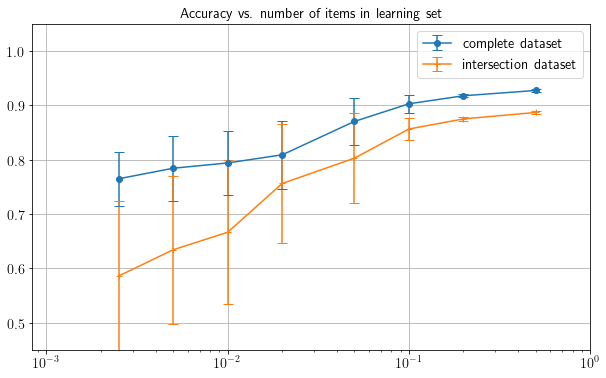

In [24]:
# Let's generate the graphs, without having to re-run everything.
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
res_all_x = results_all_x
res_all_y = results_all_y
res_all_err = results_all_err
res_int_x = results_intersection_x
res_int_y = results_intersection_y
res_int_err = results_intersection_err
# Results of Some Like It Hoax oryginal
# res_all_x = [10, 20, 40, 100, 200, 400, 1000]
# res_all_y = [0.9947928315412187, 0.9945765704584041, 0.9944259908687885, 0.9942717497556207, 0.9941477014847955, 0.9369124304747122, 0.7925489183080401]
# res_all_err = [0.00018177945073084267, 0.0001663545936217604, 0.0001440948332039384, 9.8616786904011806e-05, 8.3849643572967626e-05, 0.081584186225229241, 0.15831802229801958]
# res_int_x = [10, 20, 40, 100, 200, 400, 1000]
# res_int_y = [0.8981516687790452, 0.8505363217930758, 0.8258925611777322, 0.744059529524724, 0.6773977837218189, 0.5783037926434152, 0.519162702188392]
# res_int_err = [0.015822423827105362, 0.038183501343605319, 0.06444397351136516, 0.10609695794657316, 0.13381654475491597, 0.12521980663556254, 0.1100818925571475]

# res_gt2_x = [10, 20, 50, 100, 200, 400, 1000]
# res_gt2_y = [0.9973278594065111, 0.9970522006141249, 0.9968679719539622, 0.9968190151911995, 0.9925245944361196, 0.9633779568494931, 0.8052144572058919]
# res_gt2_err = [0.00014918118105160575, 0.00017208488861027103, 9.1833862792139789e-05, 8.3946414408233029e-05, 0.020896853639959776, 0.065442264421548352, 0.16442557191302057]

# We need the fractions
res_a_x = [1.0 / x for x in res_all_x]
res_i_x = [1.0 / x for x in res_int_x]
# res_a_x = [x * nposts for x in res_a_x]
# Builds the plots.
fig, ax = plt.subplots(1)
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='complete dataset')
# ax.errorbar(res_a_x, res_gt2_y, yerr=res_gt2_err, marker='x', label='multipage dataset')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='+', label='intersection dataset')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/1.0)
ax.legend()
ax.grid()
plt.title('Accuracy vs. number of items in learning set')
plt.plot()
plt.savefig('accuracy_vs_perc.pdf')

In [33]:
# Let's define the results from the other notebook on logistic regression.
# See ../logistic_regression/logreg_tests_final.ipynb 

# Results of Some Like It Hoax oryginal
# logi_res_all_y = [0.96669677419354827, 0.95533989813242781, 0.93099144173798531, 0.90329749103942636, 0.84348699993516163, 0.74553227266847766, 0.63488149822408779]
# logi_res_all_err = [0.0055568473928726322, 0.0096648261910718368, 0.019235373404428768, 0.038534806597708672, 0.059711620024988706, 0.086215312070645644, 0.11551090232666143]
# logi_res_int_y = [0.91654203633291076, 0.89193315989593758, 0.84144907856450035, 0.77512049927988469, 0.70986052732136029, 0.63810367829235748, 0.56102949571836336]
# logi_res_int_err = [0.0077756103084875598, 0.013865324498876704, 0.029058334540871818, 0.047490066556372029, 0.05720552897645028, 0.060875349450386827, 0.054692571945068366]
# Mine
logi_res_all_y = [0.9345701932858597, 0.9259831505325069, 0.9167205934298833, 0.9068228364901947, 0.8884720690326346, 0.8723185613359025, 0.8514371525337081, 0.808389852116267]
logi_res_all_err = [0.0024486757316576385, 0.0022813016837548348, 0.002515714363507264, 0.004475572764453983, 0.009863661481339969, 0.01238009548686527, 0.02237856910107369, 0.06698978242554172]
logi_res_int_y = [0.9111224327336411, 0.9011741293532336, 0.8928586591190519, 0.8821032344561758, 0.8647940865892292, 0.8415100104526814, 0.8160160000000001, 0.7612034155294869]
logi_res_int_err = [0.002941655225596091, 0.002820259301581182, 0.004184118937850038, 0.004491790962440057, 0.010124917748065357, 0.017503170546246616, 0.02282316857931869, 0.056907337639747875]

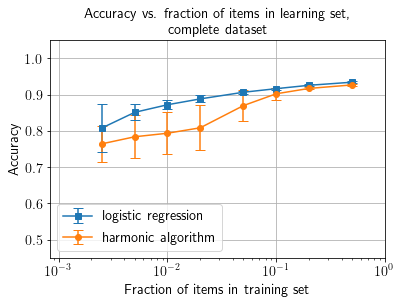

In [34]:
# Let us now plot the results, on the same dataset, of logistic and harmonic.
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(res_a_x, logi_res_all_y, yerr=logi_res_all_err, marker='s', label='logistic regression')
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='harmonic algorithm')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/1.0)
ax.legend()
ax.grid()
plt.xlabel('Fraction of items in training set')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. fraction of items in learning set,\ncomplete dataset')
plt.plot()
plt.savefig('accuracy_vs_fraction_all_s.pdf', bbox_inches='tight')

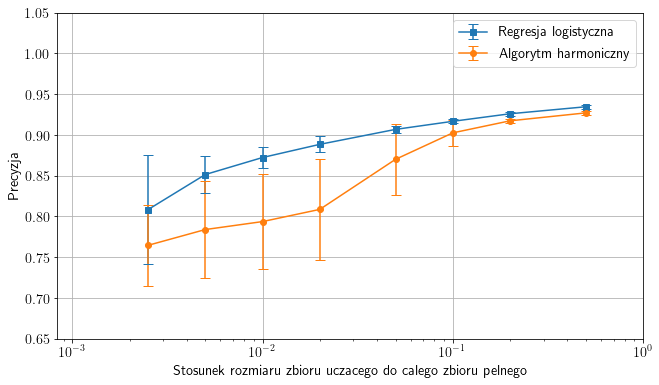

In [35]:
# Let us now plot the results, on the same dataset, of logistic and harmonic.

fig, ax = plt.subplots(figsize=(10.5, 6))
ax.errorbar(res_a_x, logi_res_all_y, yerr=logi_res_all_err, marker='s', label='Regresja logistyczna')
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='Algorytm harmoniczny')
plt.ylim(0.65, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/1.0)
ax.legend()
ax.grid()
plt.xlabel('Stosunek rozmiaru zbioru uczacego do calego zbioru pelnego')
plt.ylabel('Precyzja')
# plt.title('Precyzja a wielkosc zbioru uczacego dla zbioru pelnego')
plt.plot()
plt.savefig('accuracy_vs_fraction_all_b.pdf', bbox_inches='tight')

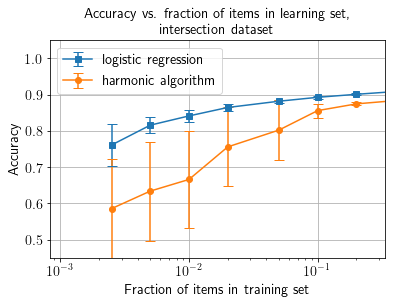

In [36]:
# Now the same, but for the intersection dataset.
fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(res_a_x, logi_res_int_y, yerr=logi_res_int_err, marker='s', label='logistic regression')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='o', label='harmonic algorithm')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/3.0)
ax.legend()
plt.xlabel('Fraction of items in training set')
plt.ylabel('Accuracy')
ax.grid()
plt.title('Accuracy vs. fraction of items in learning set,\n intersection dataset')
plt.plot()
plt.savefig('accuracy_vs_fraction_int_s.pdf', bbox_inches='tight')

In [37]:
res_a_x

[0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.0025]

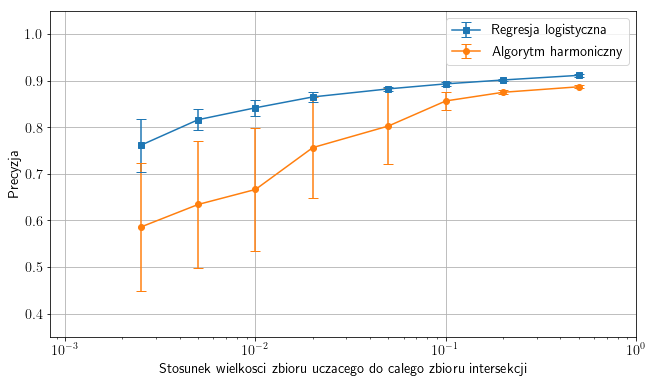

In [38]:
# Now the same, but for the intersection dataset.
fig, ax = plt.subplots(figsize=(10.5, 6))
# res_a_x = [12562.0, 6281.0, 2512.0, 1256.0, 628.0, 251.0, 125.0, 62.0, 31.0]
ax.errorbar(res_a_x, logi_res_int_y, yerr=logi_res_int_err, marker='s', label='Regresja logistyczna')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='o', label='Algorytm harmoniczny')
plt.ylim(0.35, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/1.0)
ax.legend()
plt.xlabel('Stosunek wielkosci zbioru uczacego do calego zbioru intersekcji')
plt.ylabel('Precyzja')
ax.grid()
# plt.title('Precyzja vs. wielkosc zbioru uczacego dla zbioru intersekcji')
plt.plot()
plt.savefig('accuracy_vs_fraction_int_b.pdf', bbox_inches='tight')

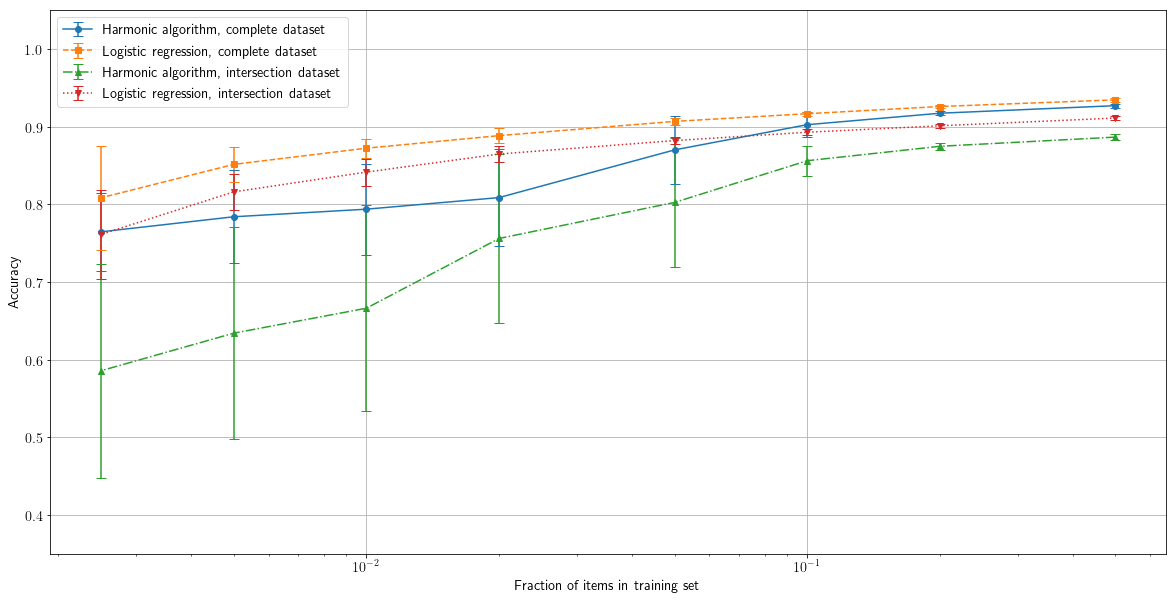

In [30]:
# We can also produce all four in the same graph, in case we lack space.
fig, ax = plt.subplots(figsize=(20,10))
ax.errorbar(res_a_x, res_all_y, yerr=res_all_err, marker='o', label='Harmonic algorithm, complete dataset')
ax.errorbar(res_a_x, logi_res_all_y, yerr=logi_res_all_err, marker='s', ls='--', label='Logistic regression, complete dataset')
ax.errorbar(res_a_x, res_int_y, yerr=res_int_err, marker='^', ls='-.', label='Harmonic algorithm, intersection dataset')
ax.errorbar(res_a_x, logi_res_int_y, yerr=logi_res_int_err, marker='v', ls=':', label='Logistic regression, intersection dataset')
plt.ylim(0.35, 1.05)
plt.xscale('log')
plt.xlabel('Fraction of items in training set')
plt.ylabel('Accuracy')
ax.legend()
ax.grid()
plt.plot()
plt.savefig('accuracy_vs_fraction_joint.pdf', bbox_inches='tight')

In [31]:
# Now we do the same as above, BUT resampling so that we sample each item
# with probability proportional to the number of likes.
reload(voting)
TESTS = [(10, 50), (20, 50), (50, 50), (100, 50), (200, 50), (400, 50), (1000, 50)]
results_all_edges_x = []
results_all_edges_y = []
results_all_edges_err = []
g = voting.VotingGraph()
add_data(g, use_all=True)
for num_chunks, num_eval_chunks in TESTS:
    cs = []
    for i in range(num_eval_chunks):
        cs.append(g.evaluate_inference_selecting_prop_likes(1.0 / num_chunks))
    results_all_edges_x.append(num_chunks)
    results_all_edges_y.append(np.average(cs))
    results_all_edges_err.append(np.std(cs))
print "results_all_edges_x = ", results_all_edges_x
print "results_all_edges_y = ", results_all_edges_y
print "results_all_edges_err = ",  results_all_edges_err
        

The graph has been built!
results_all_edges_x =  [10, 20, 50, 100, 200, 400, 1000]
results_all_edges_y =  [0.8992686736722522, 0.889661666778772, 0.8727164840897236, 0.8354766668818177, 0.8141493802581722, 0.7831005765534914, 0.7545896500991494]
results_all_edges_err =  [0.0026926824245323317, 0.005510893812927592, 0.014759040677305529, 0.053164080451607074, 0.0566357676842046, 0.05915675803830008, 0.06946712482714722]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

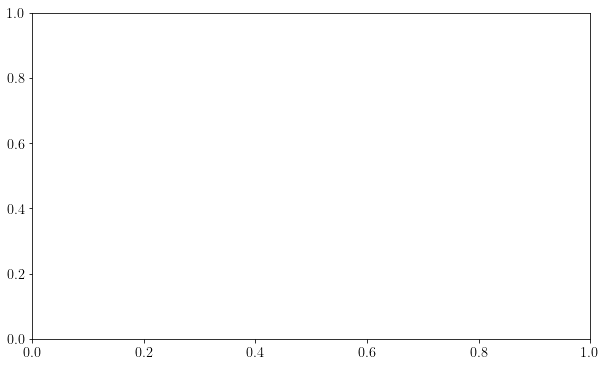

In [32]:
# Now for a comparison graph.
# res_int_x = [10, 20, 50, 100, 200, 400, 1000]
# res_int_y = [0.897950992817913, 0.8580698419051431, 0.8208923375363725, 0.7617321171387422, 0.6787648070309514, 0.6216285496474175, 0.5144928639391056]
# res_int_err = [0.016882041525877665, 0.039889350640687743, 0.063391675604248701, 0.10959444258799378, 0.14373167394339534, 0.13662163819741741, 0.10275693241854568]
# res_edg_x = [10, 20, 50, 100, 200, 400, 1000]
# res_edg_y = [0.88999788762146181, 0.87536521913147891, 0.82294277400581961, 0.72839750360057598, 0.67358937613451797, 0.63884981894415849, 0.59327719097916076]
# res_edg_err = [0.0068357969684385966, 0.0084777131391844795, 0.037350044990327166, 0.085970631359878633, 0.09539911360266122, 0.10455997072894992, 0.10284262914317449]

res_edg_x = results_all_edges_x 
res_edg_y = results_all_edges_y 
res_edg_err = results_all_edges_err 

# We need the fractions
res_e_x = [1.0 / x for x in res_edg_x]
res_i_x = [1.0 / x for x in res_int_x]
# Builds the plots.
fig, ax = plt.subplots(1)
ax.errorbar(res_a_x, res_edg_y, yerr=res_edg_err, marker='o', label='likes sampling')
ax.errorbar(res_i_x, res_int_y, yerr=res_int_err, marker='o', label='item sampling')
plt.ylim(0.45, 1.05)
plt.xscale('log')
plt.xlim(1/1200.0, 1/9.0)
ax.legend()
ax.grid()
fig.suptitle('Accuracy vs. fraction of items in learning set, intersection dataset')
plt.plot()
plt.savefig('accuracy_like_sampling.pdf')

In [39]:
# First, we do the analysis of leave-one-page-out. 
reload(voting)
frac_correct_all = [] # On complete graph
frac_correct_w = []
# First, for all. 
g = voting.VotingGraph()
add_data(g, use_all=True)
for pg in pages:
    print "page:", pg
    # Creates the function that classifies items.
    def is_learning(itid):
        return itid.split('_')[0] != pg
    fc = g.evaluate_inference_given_learning(is_learning)
    print "For all, correctness:", fc
    frac_correct_all.append(fc)
    frac_correct_w.append(posts_per_page[pg])
print "Final average correctness for leave-one-page-out all:", np.average(frac_correct_all)
print "Standard deviation:", np.std(frac_correct_all)


The graph has been built!
page: 581793998
For all, correctness: 0.979529170931
page: 241488377
For all, correctness: 0.0838323353293
page: 930919729254010885
For all, correctness: 0.00230813618003
page: 864116008910548992
For all, correctness: 1.0
page: 39480709
For all, correctness: 0.944134078212
page: 37664893
For all, correctness: 0.948275862069
page: 1901341021
For all, correctness: 0.993103448276
page: 562800078
For all, correctness: 0.991869918699
page: 86058123
For all, correctness: 0.904
page: 831151718
For all, correctness: 0.905797101449
page: 2863515755
For all, correctness: 0.549295774648
page: 194399035
For all, correctness: 0.904993909866
page: 844805327254011905
For all, correctness: 0.90873015873
page: 1359279284
For all, correctness: 0.0
page: 469251331
For all, correctness: 0.762376237624
page: 47295451
For all, correctness: 0.0534562211982
page: 19179390
For all, correctness: 0.981981981982
page: 493172275
For all, correctness: 1.0
page: 88763077
For all, correctnes

In [40]:
# We do the analysis of leave-one-page-out, also for the intersection dataset.
reload(voting)
frac_correct_all = [] # On complete graph
frac_correct_w = []
frac_correct_int = []
# First, for all. 
g = voting.VotingGraph()
add_data(g, use_all=False)
for pg in pages:
    print "page:", pg
    # Creates the function that classifies items.
    def is_learning(itid):
        return itid.split('_')[0] != pg
    fc = g.evaluate_inference_given_learning(is_learning)
    print "For all, correctness:", fc
    frac_correct_int.append(fc)
    frac_correct_w.append(posts_per_page[pg])
print "Final average correctness for leave-one-page-out intersection:", np.average(frac_correct_int, weights=frac_correct_w)


The graph has been built!
page: 581793998
For all, correctness: 0.938166311301
page: 241488377
For all, correctness: 0.0810810810811
page: 930919729254010885
For all, correctness: 0.00438871473354
page: 864116008910548992
For all, correctness: 0.981042654028
page: 39480709
For all, correctness: 0.85401459854
page: 37664893
For all, correctness: 0.837837837838
page: 1901341021
For all, correctness: 0.94623655914
page: 562800078
For all, correctness: 0.957746478873
page: 86058123
For all, correctness: 0.745098039216
page: 831151718
For all, correctness: 0.86815920398
page: 2863515755
For all, correctness: 0.473684210526
page: 194399035
For all, correctness: 0.807283763278
page: 844805327254011905
For all, correctness: 0.729957805907
page: 1359279284
For all, correctness: 0.0
page: 469251331
For all, correctness: 0.7125
page: 47295451
For all, correctness: 0.0292177191329
page: 19179390
For all, correctness: 0.926829268293
page: 493172275
For all, correctness: 0.846153846154
page: 8876307

In [41]:
# Now, let's try to keep HALF of the pages out. 
# Now, we do the analysis in which we randomly select two 
# pages hoax and two non-hoax, and we learn from those alone.
reload(voting)
frac_correct_all_half = [] # On complete graph
weights_correct_all_half = []
fraction_pages = 0.5
# First, for all. 
g = voting.VotingGraph()
add_data(g, use_all=True)
num_hoax_in = max(1, int(0.5 + len(hoax_pages) * fraction_pages))
num_nonhoax_in = max(1, int(0.5 + len(nonhoax_pages) * fraction_pages))
hoax_pages_l = list(hoax_pages)
nonhoax_pages_l = list(nonhoax_pages)
for _ in range(50):
    # Picks pages in and out.
    random.shuffle(hoax_pages_l)
    random.shuffle(nonhoax_pages_l)
    learn_pages = hoax_pages_l[:num_hoax_in] + nonhoax_pages_l[:num_nonhoax_in]
    test_pages = hoax_pages_l[num_hoax_in:] + nonhoax_pages_l[num_nonhoax_in:]
    # Computes the weight of the run.
    num_learn_posts = np.sum([posts_per_page[p] for p in learn_pages])
    num_test_posts = np.sum([posts_per_page[p] for p in test_pages])
    w = num_learn_posts * num_test_posts
    print "N learn", num_learn_posts, "N test", num_test_posts, "w", w
    # Defines the function.
    def is_learning(itid):
        return itid.split('_')[0] in learn_pages
    fc = g.evaluate_inference_given_learning(is_learning)
    print "Learning from 2 of each kind, all:", fc
    frac_correct_all_half.append(fc)
    weights_correct_all_half.append(w)

print "Final average correctness for learning from half of each kind, all:", np.average(frac_correct_all_half, weights=weights_correct_all_half)
print "avg", np.average(frac_correct_all_half)
print "stdev", np.std(frac_correct_all_half)



The graph has been built!
N learn 9219.0 N test 6508.0 w 59997252.0
Learning from 2 of each kind, all: 0.614024201055
N learn 10643.0 N test 5084.0 w 54109012.0
Learning from 2 of each kind, all: 0.490122481233
N learn 10073.0 N test 5654.0 w 56952742.0
Learning from 2 of each kind, all: 0.497415790412
N learn 6546.0 N test 9181.0 w 60098826.0
Learning from 2 of each kind, all: 0.459840454595
N learn 9216.0 N test 6511.0 w 60005376.0
Learning from 2 of each kind, all: 0.549798948345
N learn 6937.0 N test 8790.0 w 60976230.0
Learning from 2 of each kind, all: 0.577833695528
N learn 8684.0 N test 7043.0 w 61161412.0
Learning from 2 of each kind, all: 0.340704808104
N learn 10828.0 N test 4899.0 w 53046372.0
Learning from 2 of each kind, all: 0.873503920759
N learn 9165.0 N test 6562.0 w 60140730.0
Learning from 2 of each kind, all: 0.654122686248
N learn 7045.0 N test 8682.0 w 61164690.0
Learning from 2 of each kind, all: 0.501907293954
N learn 8793.0 N test 6934.0 w 60970662.0
Learning 

In [42]:
# Now, let's try to keep HALF of the pages out. 
# Now, we do the analysis in which we randomly select two 
# pages hoax and two non-hoax, and we learn from those alone.
reload(voting)
frac_correct_int_half = [] # On complete graph
weights_correct_int_half = []
fraction_pages = 0.5
# First, for all. 
g = voting.VotingGraph()
add_data(g, use_all=False)
num_hoax_in = max(1, int(0.5 + len(hoax_pages) * fraction_pages))
num_nonhoax_in = max(1, int(0.5 + len(nonhoax_pages) * fraction_pages))
hoax_pages_l = list(hoax_pages)
nonhoax_pages_l = list(nonhoax_pages)
for _ in range(50):
    # Picks pages in and out.
    random.shuffle(hoax_pages_l)
    random.shuffle(nonhoax_pages_l)
    learn_pages = hoax_pages_l[:num_hoax_in] + nonhoax_pages_l[:num_nonhoax_in]
    test_pages = hoax_pages_l[num_hoax_in:] + nonhoax_pages_l[num_nonhoax_in:]
    # Computes the weight of the run.
    num_learn_posts = np.sum([posts_per_page[p] for p in learn_pages])
    num_test_posts = np.sum([posts_per_page[p] for p in test_pages])
    w = num_learn_posts * num_test_posts
    print "N learn", num_learn_posts, "N test", num_test_posts, "w", w
    # Defines the function.
    def is_learning(itid):
        return itid.split('_')[0] in learn_pages
    fc = g.evaluate_inference_given_learning(is_learning)
    print "Learning from half of each kind, all:", fc
    frac_correct_int_half.append(fc)
    weights_correct_int_half.append(w)
print "Final average correctness for learning from half of each kind, intersection:", np.average(frac_correct_int_half, weights=weights_correct_int_half)
print "avg", np.average(frac_correct_int_half)
print "stdev", np.std(frac_correct_int_half)


The graph has been built!
N learn 9044.0 N test 6683.0 w 60441052.0
Learning from half of each kind, all: 0.45927306617
N learn 6070.0 N test 9657.0 w 58617990.0
Learning from half of each kind, all: 0.445855206934
N learn 4741.0 N test 10986.0 w 52084626.0
Learning from half of each kind, all: 0.61625770187
N learn 7330.0 N test 8397.0 w 61550010.0
Learning from half of each kind, all: 0.344406879318
N learn 6202.0 N test 9525.0 w 59074050.0
Learning from half of each kind, all: 0.560790051207
N learn 7312.0 N test 8415.0 w 61530480.0
Learning from half of each kind, all: 0.367824238129
N learn 9907.0 N test 5820.0 w 57658740.0
Learning from half of each kind, all: 0.710180827347
N learn 8907.0 N test 6820.0 w 60745740.0
Learning from half of each kind, all: 0.521676761237
N learn 8445.0 N test 7282.0 w 61496490.0
Learning from half of each kind, all: 0.544417877506
N learn 5903.0 N test 9824.0 w 57991072.0
Learning from half of each kind, all: 0.561596520404
N learn 10263.0 N test 54